# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio
#from scipy.misc.pilutil import imread,imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import skimage.transform

In [1]:
!rm -rf ~/.local/share/Trash/*

In [2]:
!df -H

Filesystem      Size  Used Avail Use% Mounted on
overlay          17G  1.9M   17G   1% /
tmpfs            68M     0   68M   0% /dev
tmpfs           136G     0  136G   0% /sys/fs/cgroup
shm             2.2G     0  2.2G   0% /dev/shm
/dev/sdb        3.9T  2.9T  1.1T  73% /home
tmpfs           136G   13k  136G   1% /proc/driver/nvidia
/dev/sda2       3.8T  842G  2.8T  24% /usr/bin/nvidia-smi
udev            136G     0  136G   0% /dev/nvidia3
tmpfs           136G     0  136G   0% /proc/asound
tmpfs           136G     0  136G   0% /proc/acpi
tmpfs           136G     0  136G   0% /proc/scsi
tmpfs           136G     0  136G   0% /sys/firmware


We set the random seed so that the results don't vary drastically.

In [2]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [4]:
# def ini_param(batch_size,epoch):
#     train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
#     batch_size = batch_size # experiment with the batch size
#     enable_augmentation = False # augmentation of Data
#     # sequence ids
#     # selecting alternate frames from 7 to 26.
#     seq_idx = range(7,26,2)
#     # image dimensions
#     dim_x, dim_y = 120, 120
#     train_path = '/home/datasets/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
#     val_path =  '/home/datasets/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#     #multiply number train seq by 2 when using augmentation
#     multiplier = 1
#     if enable_augmentation:
#         multiplier = 2
#     num_train_sequences = len(train_doc)*multiplier
#     print('# training sequences =', num_train_sequences)

#     num_val_sequences = len(val_doc)
#     print('# validation sequences =', num_val_sequences)

#     num_epochs = epoch # choose the number of epochs
#     print ('# epochs =', num_epochs)
#     # testing generative 
#     test_gen = generator(train_path, train_doc, 1,seq_idx, dim_x, dim_y,is_train = True, augmention = True, debug = True)
#     d = next(test_gen)[0]
#     #input shape for the st layer
#     input_shape = (len(seq_idx), dim_x, dim_y, 3)
#     np.random.seed(30)
#     #return input_shape,train_path,val_path,train_doc, val_doc,batch_size,enable_augmentation,seq_idx, dim_x, dim_y,num_train_sequences,num_val_sequences
    

In [9]:
#def train(model,train_path,val_path,train_doc, val_doc,batch_size,enable_augmentation,seq_idx, dim_x, dim_y,num_train_sequences,num_val_sequences):
def train(batch_size,epoch,train=0):
    train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
    batch_size = batch_size # experiment with the batch size
    enable_augmentation = False # augmentation of Data
    # sequence ids
    # selecting alternate frames from 7 to 26.
    seq_idx = range(7,26,2)
    # image dimensions
    dim_x, dim_y = 120, 120
    train_path = '/home/datasets/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
    val_path =  '/home/datasets/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

    #multiply number train seq by 2 when using augmentation
    multiplier = 1
    if enable_augmentation:
        multiplier = 2
    num_train_sequences = len(train_doc)*multiplier
    print('# training sequences =', num_train_sequences)

    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)

    num_epochs = epoch # choose the number of epochs
    print ('# epochs =', num_epochs)
    # testing generative 
    test_gen = generator(train_path, train_doc, 1,seq_idx, dim_x, dim_y,is_train = True, augmention = True, debug = True)
    d = next(test_gen)[0]
    #input shape for the st layer
    input_shape = (len(seq_idx), dim_x, dim_y, 3)
    np.random.seed(30)
    if train==1:
        optimiser = tf.keras.optimizers.Adam(0.01) #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print(model.summary())
        curr_dt_time = datetime.datetime.now()
        train_generator = generator(train_path, train_doc, batch_size,seq_idx, dim_x, dim_y, is_train = True, augmention = enable_augmentation)
        val_generator = generator(val_path, val_doc, batch_size,seq_idx, dim_x, dim_y)
        model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

        callbacks_list = [checkpoint, LR]
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        plt.figure(figsize=(20,6))
        ax1 = plt.subplot(121)
        ax1 = plt.plot(history.history['loss'])
        ax1 = plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='lower left')
        ax2 = plt.subplot(122)
        ax2 = plt.plot(history.history['categorical_accuracy'])
        ax2 = plt.plot(history.history['val_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('categorical_accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='lower left')
    return input_shape

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, seq_idx,dim_x,dim_y,is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

           
                    resized_im=skimage.transform.resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)
                        

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



### Experiment - 1 
**Conv3D batch -128 and epoch 10**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


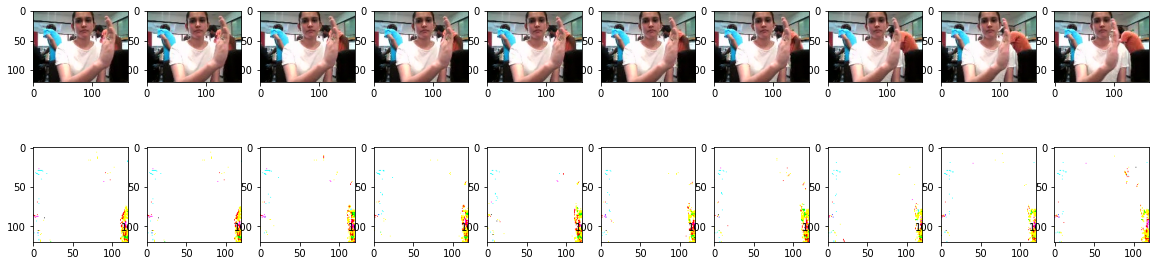

In [13]:
input_shape=train(128,10)

In [14]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)              

2022-11-10 15:50:11.719094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


6/6 [==============================] - ETA: 0s - loss: 43.5973 - categorical_accuracy: 0.1641
Epoch 00001: saving model to model_init_exp_16_2022-11-1015_50_02.106786/model-00001-43.59727-0.16406-1.31670-0.17969.h5
6/6 [==============================] - 53s 10s/step - loss: 43.5973 - categorical_accuracy: 0.1641 - val_loss: 1.3167 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 1.4002 - categorical_accuracy: 0.1771
Epoch 00002: saving model to model_init_exp_16_2022-11-1015_50_02.106786/model-00002-1.40016-0.17708-1.25989-0.13281.h5
6/6 [==============================] - 52s 10s/step - loss: 1.4002 - categorical_accuracy: 0.1771 - val_loss: 1.2599 - val_categorical_accuracy: 0.1328 - lr: 0.0100
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 1.3927 - categorical_accuracy: 0.1615
Epoch 00003: saving model to model_init_exp_16_2022-11-1015_50_02.106786/model-00003-1.39273-0.16146-1.26174-0.12500.h5
6/6 [=

(10, 120, 120, 3)

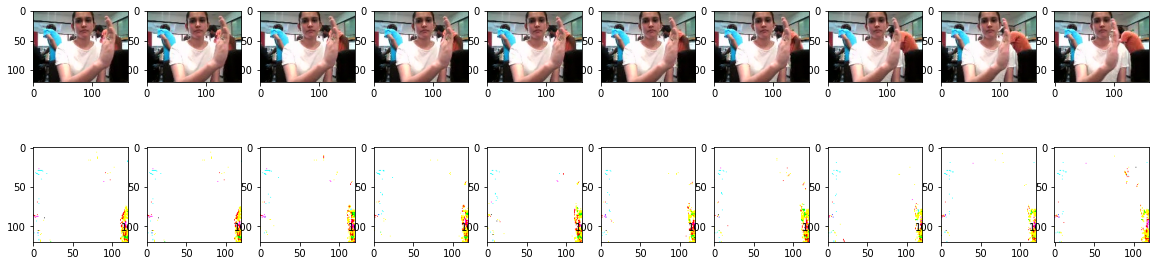

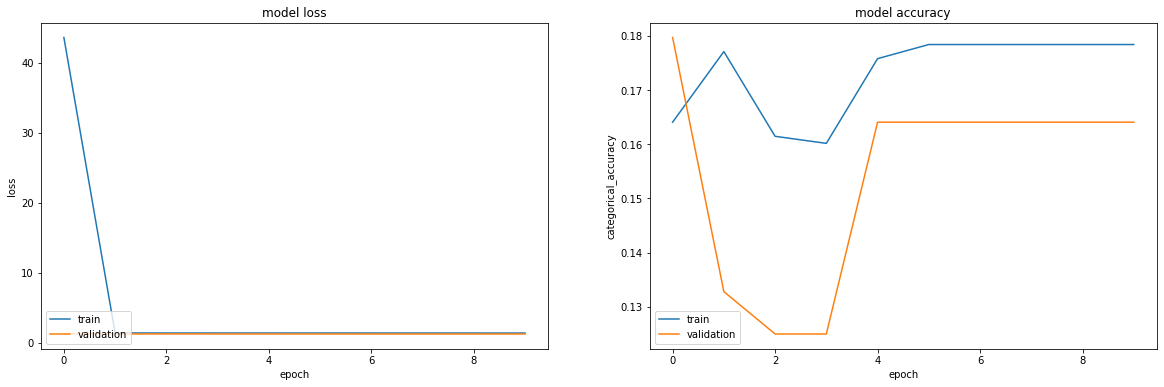

In [15]:
train(128,10,train=1)

### Experiment 2
**Conv 3D with batch 32 and epoch 10**

# training sequences = 663
# validation sequences = 100
# epochs = 10


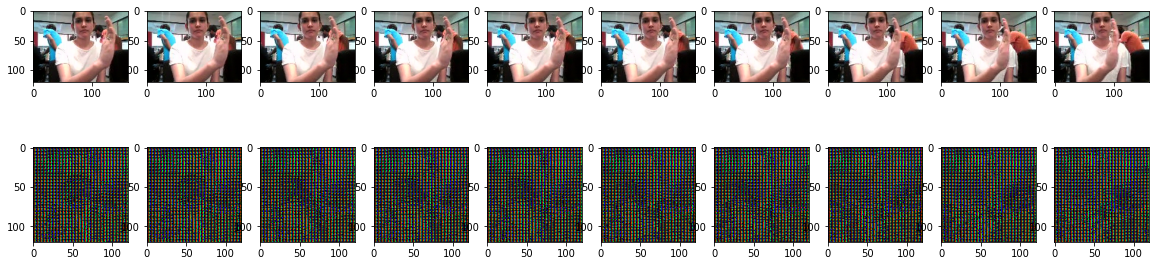

In [17]:
input_shape=train(32,10)

In [18]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

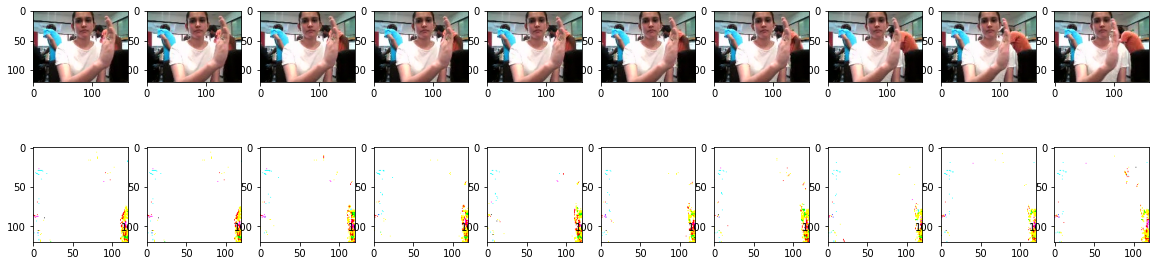

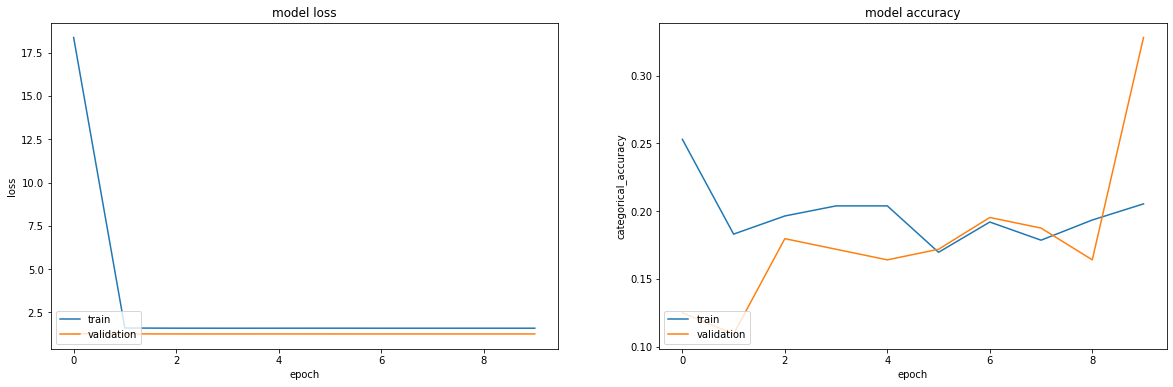

In [19]:
input_shape=train(32,10,train=1)

##### We can now fix 32 batch size as constant and increase appoches only if there is increase in model performanace currently it is flickering in 17 and 18% which is not good 

### Experiment - 3
**Conv3D with exta 2 conv3d layer**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


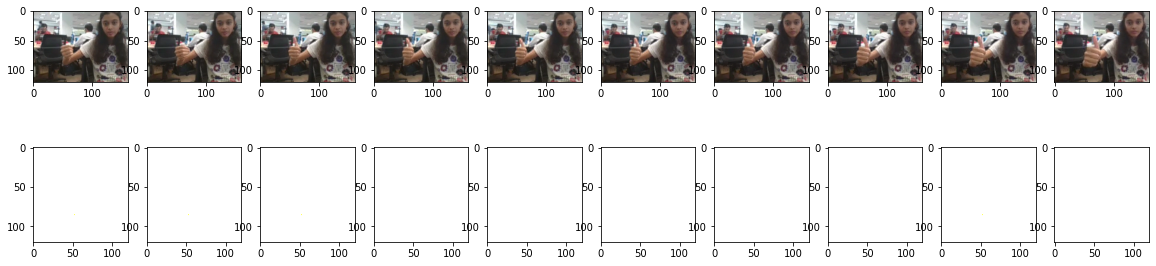

In [20]:
input_shape=train(32,10)

In [30]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256,kernel_size=3 ,activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# training sequences = 663
# validation sequences = 100
# epochs = 10
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_38 (Conv3D)          (None, 8, 118, 118, 64)   55360     
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 4, 59, 59, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 4, 59, 59, 128)    221312    
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 2, 29, 29, 128)   0         
 g3D)                                                            
                                                 

(10, 120, 120, 3)

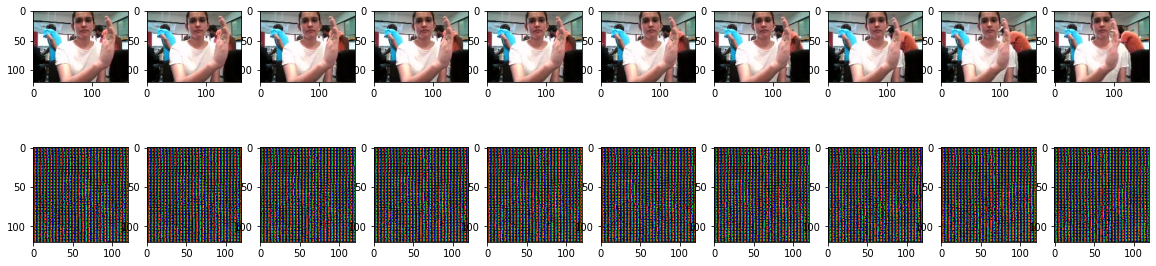

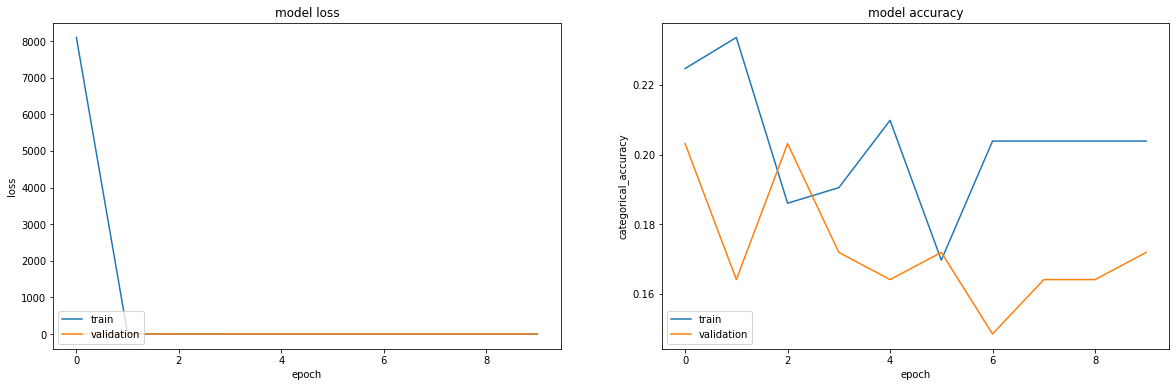

In [31]:
train(32,10,train=1)

### Experiment - 3
**Conv3D with exta 2 conv3d layer batch normalisation**

# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

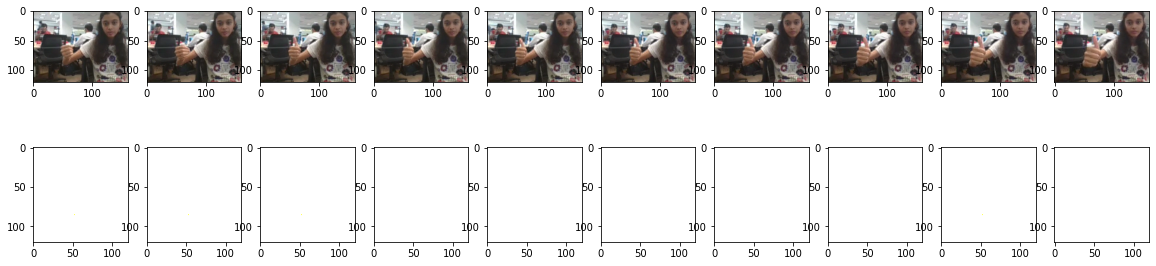

In [33]:
input_shape=train(32,10)

In [34]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256,kernel_size=3 ,activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_49 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_50 (Conv3D)          (None, 8, 118, 118, 64)   55360     
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 4, 59, 59, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 4, 59, 59, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_51 (Conv3D)          (None, 4, 59, 59, 128)    221312    
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 2, 29, 29, 128) 

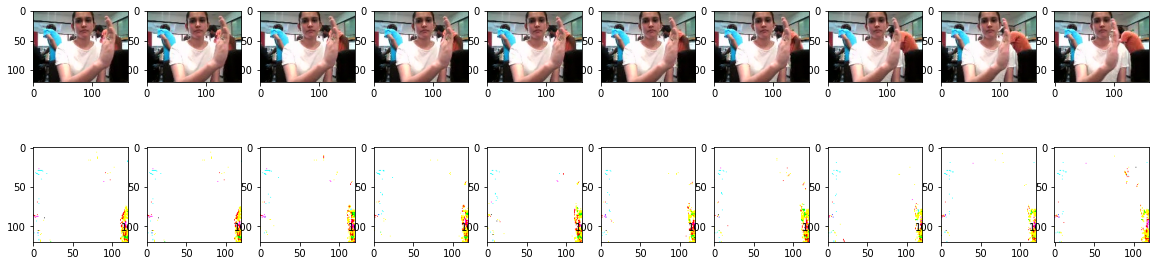

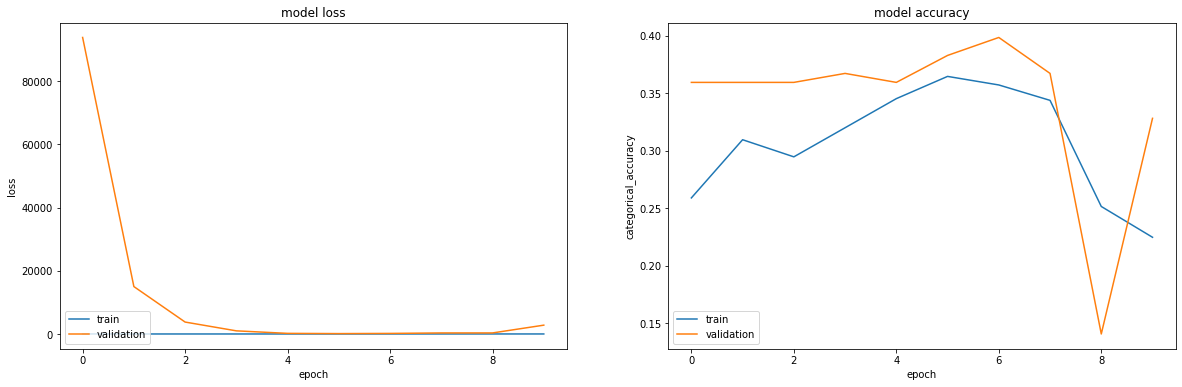

In [35]:
input_shape=train(32,10,train=1)

### Experiment - 3
**Conv3D with exta 2 conv3d layer batch normalisation and drop out 0.5**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


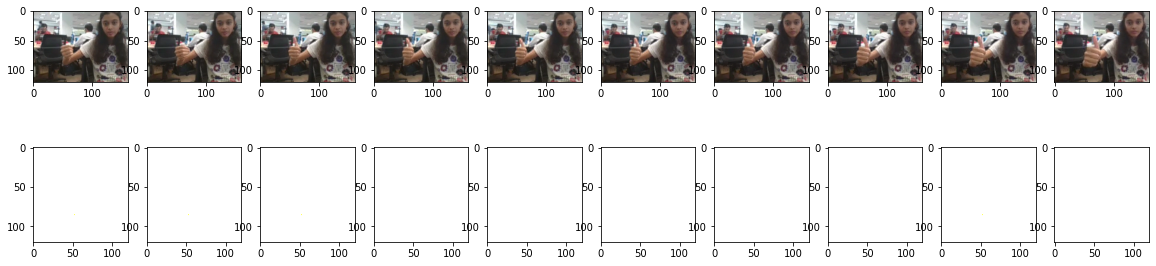

In [36]:
input_shape=train(32,10)

In [37]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256,kernel_size=3 ,activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_55 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_56 (Conv3D)          (None, 8, 118, 118, 64)   55360     
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 4, 59, 59, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 4, 59, 59, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 4, 59, 59, 64)     0         
                                                                 
 conv3d_57 (Conv3D)          (None, 4, 59, 59, 128)  

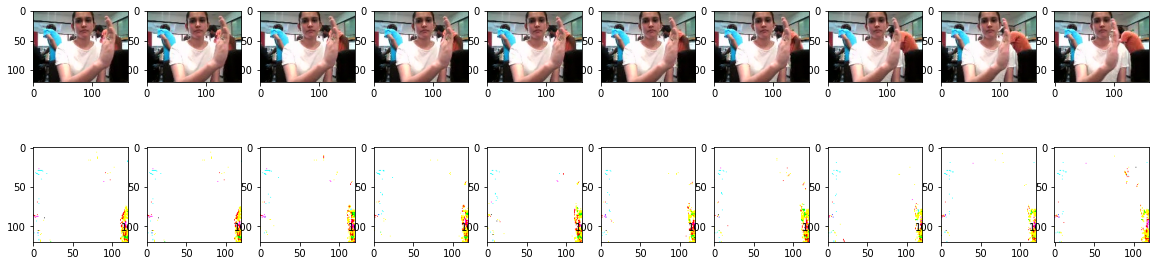

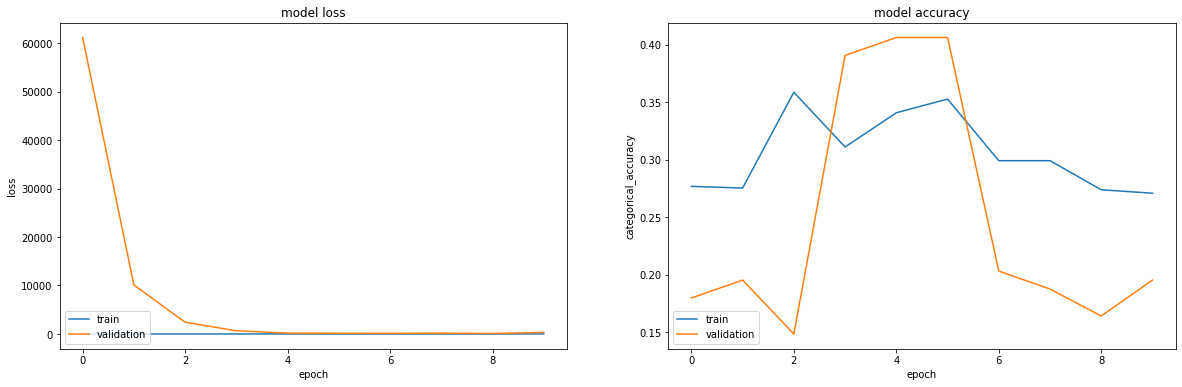

In [38]:
input_shape=train(32,10,train=1)

# training sequences = 663
# validation sequences = 100
# epochs = 50


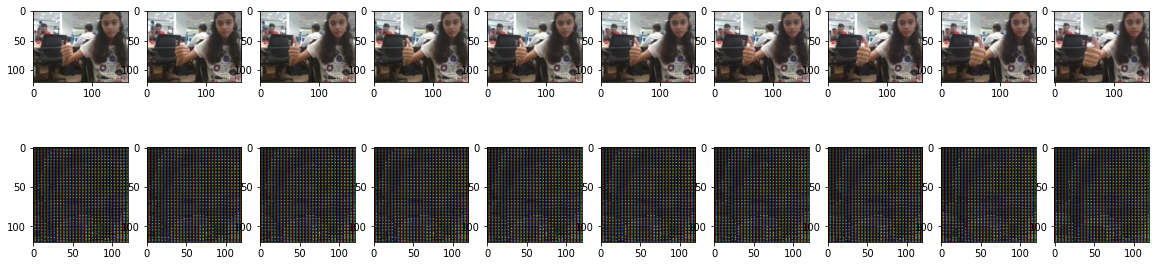

In [39]:
input_shape=train(32,50)

In [40]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256,kernel_size=3 ,activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(Conv3D(512,kernel_size=3, activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
input_shape=train(32,50,train=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# training sequences = 663
# validation sequences = 100
# epochs = 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_61 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_62 (Conv3D)          (None, 8, 118, 118, 64)   55360     
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 4, 59, 59, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 4, 59, 59, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 4, 59, 59, 64)     0         
                                                                 
 conv3d_63 (Conv3D)          (None, 4, 59, 59, 128)  